# diverse development using pennlinckit

In [1]:
import sys
factor = sys.argv[1]

#### pennlinckit contains data, plotting, brain, network science, and math functions common to neuroscience projects

In [2]:
import pennlinckit

#### standard libraries

In [3]:
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr, spearmanr

In [4]:
data = pennlinckit.data.dataset('pnc')

In [5]:
data.load_matrices('rest')

## What is in this object?

#### You will probably be most interested in the matrices:

In [6]:
data.matrix.shape

(1601, 400, 400)

#### You can always double check what dataset you called with:

In [7]:
data.source

'pnc'

#### All data objects will have a "measures" method, which is a pandas dataframe with all the info you need

In [8]:
data.measures.head()

,bblid_x,subject,sex,race,race2,ethnicity,ageAtClinicalAssess1,ageAtCnb1,ageAtScan1,edu1,...,restRelMeanRMSMotion,restRelMeanRMSMotionExclude,restNSpikesMotion,restNSpikesMotionExclude,restNormCrossCorr,restNormCoverage,restCoregCrossCorr,restCoregCoverage,restVoxelwiseCoverageExclude,restRpsMapCorrectionNotApplied
0,80010,2894,1,1,1,2,260,260,261,14,...,0.097756,0.0,10.0,0.0,0.903724,0.987702,0.873996,0.989849,0.0,0
1,80179,2643,2,1,1,2,254,254,254,12,...,0.123359,0.0,9.0,0.0,0.905378,0.964365,0.900334,0.975325,0.0,1
2,80199,2637,1,5,3,1,243,244,244,12,...,0.022592,0.0,0.0,0.0,0.909586,0.989839,0.883383,0.990407,0.0,1
3,80208,3016,1,2,2,2,245,245,246,11,...,0.046629,0.0,1.0,0.0,0.900216,0.988733,0.876665,0.991539,0.0,0
4,80249,2648,2,1,1,2,250,250,250,16,...,0.684977,1.0,65.0,1.0,0.884094,0.951311,0.880534,0.976181,1.0,1


In [9]:
data.measures.columns

Index(['bblid_x', 'subject', 'sex', 'race', 'race2', 'ethnicity',
       'ageAtClinicalAssess1', 'ageAtCnb1', 'ageAtScan1', 'edu1', 'fedu1',
       'medu1', 'handednessv2', 'bblid_y', 'mood_4factorv2',
       'psychosis_4factorv2', 'externalizing_4factorv2', 'phobias_4factorv2',
       'overall_psychopathology_4factorv2', 'bblid_x', 'Overall_Efficiency',
       'Overall_Accuracy', 'Overall_Speed', 'F1_Exec_Comp_Res_Accuracy',
       'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy',
       'F1_Complex_Reasoning_Efficiency', 'F2_Memory.Efficiency',
       'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency',
       'F1_Slow_Speed', 'F2_Fast_Speed', 'F3_Memory_Speed',
       'Overall_Efficiency_Ar', 'Overall_Accuracy_Ar', 'Overall_Speed_Ar',
       'F1_Exec_Comp_Cog_Accuracy_Ar', 'F2_Social_Cog_Accuracy_Ar',
       'F3_Memory_Accuracy_Ar', 'F1_Social_Cognition_Efficiency_Ar',
       'F2_Complex_Reasoning_Efficiency_Ar', 'F3_Memory_Efficiency_Ar',
       'F4_Executive_Efficiency_Ar', 

#### Sometimes it's confusing to have all these odd names, which is why we have a data_dict method

In [10]:
data.data_dict['overall_psychopathology_4factorv2']

'GOASSESS  4Factor Bifactor Scores Overall Psychopathology (General Factor)'

#### Let's only look at subjects that have a matrix for resting-state and cognitive scores

In [11]:
data.filter('matrix')
data.filter('cognitive')
data.matrix.shape

(1390, 400, 400)

#### Let's only look at people who did not move a lot

In [12]:
data.filter('==',value=0,column='restRelMeanRMSMotionExclude')
data.matrix.shape

(1166, 400, 400)

## Let's see what regions predict what mental illness symtom factors best

In [13]:
def region_predict(data,region,factor,**model_args):
    data.targets = data.measures[factor].values
    data.features = data.matrix[:,region]
    model_args['self'] = data
    pennlinckit.utils.predict(**model_args)

In [14]:
data.matrix[np.isnan(data.matrix)]= 0.0 #the diagonal has np.nan, have to set to zero for sklearn

In [ ]:
# factor = 'F1_Exec_Comp_Res_Accuracy_RESIDUALIZED'
prediction = np.zeros((400,len(data.measures.subject)))
for node in range(400):
    region_predict(data,node,factor,**{'model':'deep','cv':'KFold','folds':5,'neurons':400,'layers':10,'remove_linear_vars':['restRelMeanRMSMotion','sex']})
    prediction[node] = data.prediction

In [144]:
data.features.shape

(1168, 400)

In [145]:
prediction_acc = np.zeros(400)
for node in range(data.matrix.shape[-1]):
    prediction_acc[node] = pearsonr(prediction[node],data.corrected_targets)[0]

In [146]:
np.save('/home/mb3152/diverse_development/data/prediction_{0}.npy'.format(factor),prediction)
np.save('/home/mb3152/diverse_development/data/prediction_acc_{0}.npy'.format(factor),prediction_acc)
np.save('/home/mb3152/diverse_development/data/prediction_regressed_targets_{0}.npy'.format(factor),data.corrected_targets)

In [ ]:
1/0

## I submitted each factor to the cluster (see submit.py)

#### Now let's look at the outputs

In [15]:
factors = ['mood_4factorv2','psychosis_4factorv2', 'externalizing_4factorv2', 'phobias_4factorv2','overall_psychopathology_4factorv2'] #clincal factors
factors = ['F1_Exec_Comp_Res_Accuracy_RESIDUALIZED','F2_Social_Cog_Accuracy_RESIDUALIZED','F3_Memory_Accuracy_RESIDUALIZED'] #cogi factors

In [16]:
all_factor_predictions = np.zeros((5,data.matrix.shape[-1],data.matrix.shape[0]))
prediction_acc = np.zeros((len(factors),data.matrix.shape[-1]))
for fidx, factor in enumerate(factors):
    prediction_acc[fidx] = np.load('/home/mb3152/diverse_development/data/prediction_acc_{0}.npy'.format(factor))
    all_factor_predictions[fidx] = np.load('/home/mb3152/diverse_development/data/prediction_{0}.npy'.format(factor))

In [21]:
# from the adult HCP
adult_pc = np.load('/home/mb3152/diverse_development/data/hcp_pc.npy').mean(axis=0)

In [22]:
adult_strength = np.load('/home/mb3152/diverse_development/data/hcp_strength.npy').mean(axis=0)

In [19]:
pearsonr(prediction_acc.mean(axis=0),adult_pc)

(0.2667341151865773, 6.080150209232515e-08)

In [20]:
pearsonr(prediction_acc.mean(axis=0),adult_strength)

(0.10914832363634129, 0.029060881864237942)

In [59]:
high_predict = prediction_acc.mean() + (prediction_acc.std())
flexible_nodes = (prediction_acc>high_predict).sum(axis=0)
print(pearsonr(flexible_nodes,adult_pc))

(0.1889603421999188, 0.00014371649988763848)


In [28]:
spincorrs = pennlinckit.brain.spin_test(adult_pc,flexible_nodes)
spin_stat = pennlinckit.brain.spin_stat(adult_pc,flexible_nodes,spincorrs)

In [29]:
import seaborn as sns
import matplotlib.pylab as plt
from pennlinckit import plotting
%matplotlib inline

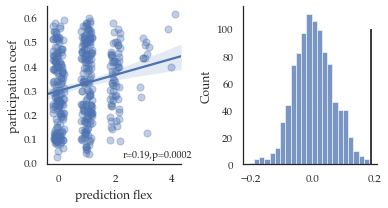

In [33]:
plt.close()
f,axes = plt.subplots(1,2,figsize=(5.5,3))
sns.regplot(x=flexible_nodes,y=adult_pc,ax=axes[0],truncate=False,x_jitter=.2,scatter_kws={"s": 50,'alpha':0.35})
plt.sca(axes[0])
r,p = pearsonr(adult_pc,flexible_nodes)
plt.text(2.25,.025,'r={0},p={1}'.format(np.around(r,2),np.around(p,4)))
plt.ylabel('participation coef')
plt.xlabel('prediction flex')
sns.histplot(spincorrs,ax=axes[1])
plt.sca(axes[1])
plt.vlines(r,0,100,colors='black')
plt.tight_layout()
sns.despine()
plt.savefig('flex.pdf')

In [34]:
flex_colors = np.zeros((400,4))
flex_colors[flexible_nodes>=2] = np.array([235,93,104,256])/256.
pennlinckit.brain.write_cifti(flex_colors,'flex_nodes')

In [35]:
for factor in factors: print (data.data_dict[factor])

GOASSESS  4Factor Bifactor Scores Mood Factor
GOASSESS  4Factor Bifactor Scores Psychosis Factor
GOASSESS  4Factor Bifactor Scores Externalizing Disorder  Factor
GOASSESS  4Factor Bifactor Scores Phobia Factor
GOASSESS  4Factor Bifactor Scores Overall Psychopathology (General Factor)


In [55]:
flexible_nodes = np.zeros((400))
for high_predict in [0.05,0.06,0.07,0.08]:
    flexible_nodes =flexible_nodes+ (prediction_acc>high_predict).sum(axis=0)

print(pearsonr(flexible_nodes,adult_pc))
flexible_nodes[flexible_nodes>=6] = 6
flex_colors = pennlinckit.brain.make_heatmap(flexible_nodes,cmap=sns.diverging_palette(220, 10,n=1001))
pennlinckit.brain.write_cifti(flex_colors,'flex_nodes_cont')

In [13]:
allen = pennlinckit.data.allen_brain_institute()

In [19]:
allen_ge = np.corrcoef(allen.expression)

In [103]:
diverse_club = adult_pc >= np.percentile(adult_pc,80)
rich_club = adult_strength >= np.percentile(adult_strength,80)
diverse_club[200:] = False
rich_club[200:] = False
diverse_ge = allen_ge[np.ix_(diverse_club,diverse_club)].flatten()
rich_ge = allen_ge[np.ix_(rich_club,rich_club)].flatten()
diverse_ge = diverse_ge[np.isnan(diverse_ge)==False]
diverse_ge = diverse_ge[diverse_ge!=1]
rich_ge = rich_ge[np.isnan(rich_ge)==False]
rich_ge = rich_ge[rich_ge!=1]
scipy.stats.ttest_ind(diverse_ge,rich_ge)

Ttest_indResult(statistic=2.77469467261896, pvalue=0.005559563269196067)